In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix
import atomInSmiles
from collections import Counter
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator, LogFormatterMathtext
from typing import List, Dict, Tuple
from torch.distributions import Normal, kl_divergence
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(device)
# os.chdir("C:\\Users\\user\\test.venv")
# print(os.getcwd())
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import umap.umap_ as umap

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

cuda


In [2]:
mm_scaler = MinMaxScaler()
class load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #Li-ion Conductivity
        self.conductivity = self.raw.iloc[:, 6:7].values
        self.conductivity = log_minmax_pipeline.fit_transform(self.conductivity.reshape(-1, 1))

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = mm_scaler.fit_transform(self.DP.reshape(-1, 1))

        #Transfer Number
        self.tn = self.raw.iloc[:, 10:11].values
        self.tn1 = self.tn
        self.tn = mm_scaler.fit_transform(self.tn.reshape(-1, 1))

        #Labels
        self.label = self.raw.iloc[:, 11:12].values

        self.properties = np.concat((self.conductivity, self.DP, self.tn), axis=-1)

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        

        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[CLS] [SOS] " + smiles +" [EOS]"))

        max_len = len(max(ais_encoding, key=len)) + 1
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        corpus.append("[PAD]")
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        
        self.vocab = vocab

        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[CLS]','[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[CLS]','[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = ais_token_num_dec_input
        self.SMILES_dec_output = ais_token_num_dec_output

        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size


        print(self.SMILES_enc.shape)
        self.properties = torch.tensor(self.properties, dtype=torch.float).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ", psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
        print(len(ais_token_num_enc[50]))
        
        self.label = torch.tensor(self.label, dtype=torch.uint8)
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i], self.label[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [3]:

Polymers = "simulation-trajectory-aggregate_aligned.csv"
dataset = load_data(Polymers)

generator = torch.Generator()
train_dataset, val_dataset = random_split(dataset, [0.75, 0.25], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[CLS]': 9, '[SOS]': 10, '[EOS]': 11, '[O;!R;CC]': 12, '[NH;!R;CC]': 13, '[*;!R;O]': 14, '[O;!R;*C]': 15, '[C;!R;*OO]': 16, '[CH;!R;CCO]': 17, '[CH;!R;CCN]': 18, '[C;!R;CNO]': 19, '[N;!R;CCC]': 20, '[C;!R;*NO]': 21, '[NH;!R;*C]': 22, '[*;!R;N]': 23, '[CH3;!R;N]': 24, '[CH;!R;CCC]': 25, '[C;!R;CCCO]': 26, '[CH;!R;CC]': 27, '[F;!R;C]': 28, '[CH2;!R;C]': 29, '[C;!R;COO]': 30, '[CH3;!R;O]': 31, '[C;!R;CCCN]': 32, '#': 33, '[C;!R;CCCC]': 34, '[CH2;!R;CS]': 35, '[C;!R;CC]': 36, '[OH;!R;C]': 37, '[S;!R;CC]': 38, '[N;!R;C]': 39, '[C;!R;CN]': 40, '[CH;!R;C]': 41, '[C;!R;CCC]': 42, '[NH2;!R;C]': 43, '[CH;!R;CFF]': 44, '[O;!R;S]': 45, '[O;!R;CN]': 46, '[CH;!R;CCS]': 47, '[CH2;!R;CF]': 48, '[CH3;!R;S]': 49, '[C;!R;CCO]': 50, '[NH;!R;CO]': 51, '[CH2;!R;*C]': 52, '[C;!R;NNO]': 53, '[C;!R;CFFF]': 54, '[C;!R;CCFF]': 55, '[C;!R;NOO]': 56, '[C;!R;OOO]':

In [4]:
def reverse_one_hot_encoding(one_hot_tensor:torch.Tensor, vocab:Dict):
    # 인덱스 → 토큰 매핑 생성
    index_to_token = {idx: token for token, idx in vocab.items()}

    # 복원된 토큰 시퀀스를 저장할 리스트
    original_tokens_list = []

    # GPU 텐서면 CPU로
    if one_hot_tensor.is_cuda:
        one_hot_tensor = one_hot_tensor.cpu()

    # one-hot → argmax (인덱스 시퀀스)
    try:
        _ = one_hot_tensor.shape[1]
        one_hot_tensor = F.softmax(one_hot_tensor, dim=-1)
        one_hot_tensor = torch.argmax(one_hot_tensor, dim=-1)
    except:
        pass  # 이미 1D 라면 그대로 둠

    # “값이 166인” 위치만 추출
    idx_166 = torch.nonzero(one_hot_tensor == 166, as_tuple=True)[0]

    idx_11 = torch.nonzero(one_hot_tensor == 11, as_tuple=True)[0]

    # 만약 166 토큰이 하나도 없으면 전체 길이 사용
    end_pos = idx_166[0].item() if len(idx_166) > 0 else one_hot_tensor.size(0)
    end_pos = idx_11[0].item() if len(idx_11) > 0 else end_pos

    # 0부터 end_pos 직전까지 토큰 복원
    for i in range(end_pos):
        token_idx = one_hot_tensor[i].item()
        original_tokens_list.append(index_to_token.get(token_idx, "<UNK>"))

    return original_tokens_list
print(dataset.test_data)
test = reverse_one_hot_encoding(dataset.test_data, dataset.vocab)
print(test)
print(atomInSmiles.decode(' '.join(test)))
#print(dataset.vocab)

def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


tensor([  9,  14,  15,   7,   6,  47,   0,   4,   1,  38,  35,   7,  12,   7,
          7,  12,  16,   0,   8,   1,   2,   3, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 1

In [5]:
import math
#from torch_pca import PCA
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        pos_embedding =  self.pe[:, :x.size(1), :]
        pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
        x =  torch.cat([x, pos_embedding], dim=2)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, nhead=4):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)

    def forward(self, query, key, value, attn_mask=None) -> torch.Tensor:
        attn_output, _ = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        return attn_output

class MY_TF_encoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", layer_norm_eps=1e-5, batch_first=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout,
                                               batch_first=batch_first)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.linear3 = nn.Linear(d_model, dim_feedforward)
        self.linear4 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm4 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        
        self.crossattn = MultiHeadAttention(d_model=d_model, nhead=nhead)

        # Activation function
        if activation == "relu":
            self.activation = F.relu
        elif activation == "gelu":
            self.activation = F.gelu
        else:
            raise ValueError("Unsupported activation: {}".format(activation))

    def forward(self, src, prop, src_mask=None, src_key_padding_mask=None) -> torch.Tensor:
        # Self-attention
        attn_output, _ = self.self_attn(src, src, src,
                                        attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        # Feedforward
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff)
        src = self.norm2(src)

        # Self-attention (properties)
        attn_output, _ = self.self_attn(prop, prop, prop,
                                        attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        prop = prop + self.dropout1(attn_output)
        prop = self.norm1(prop)
        # Feedforward (properties)
        ff = self.linear2(self.dropout(self.activation(self.linear1(prop))))
        prop = prop + self.dropout2(ff)
        prop = self.norm2(prop)

        # Cross-Attention
        crossattn = self.crossattn(src, prop, prop)
        src = src + self.dropout3(crossattn)
        src = self.norm3(src)

        # Feedfoward
        ff = self.linear4(self.dropout(self.activation(self.linear3(src))))
        src = src + self.dropout4(ff)
        src = self.norm4(src)
        return src

In [6]:
class TFEncoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        
        self.encoderLayer = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoder = TransformerEncoder(encoder_layer=self.encoderLayer, num_layers=4, norm=self.normLayer)
        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

        self.conv = nn.Conv1d(3, 265, 1)


    def forward(self, smiles_enc:torch.Tensor, properties:torch.Tensor) -> torch.Tensor:
        smiles_enc = self.input_embedding_smiles(smiles_enc) # [B, seq_len, d_model // 2]
        enc_input_0 = self.pos_encoding(torch.cat((smiles_enc, properties),dim=1)) # [B, seq_len, 256]

        encoded_0 = self.encoder(enc_input_0)
        return encoded_0

class TFDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2, latent_dim=64):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)

        self.decoderLayer = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder = TransformerDecoder(decoder_layer=self.decoderLayer,
                                          num_layers=2,
                                          norm=self.normLayer)

        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, dec_input : torch.Tensor, latent : torch.Tensor) -> torch.Tensor:
        dec_input = self.input_embedding_smiles(dec_input)
        dec_input_0 = self.pos_encoding(dec_input)
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
        memory_mask = self.generate_square_subsequent_mask(latent.shape[1]).to(device)

        decoded = self.decoder(dec_input_0, latent, tgt_mask=x_mask, memory_mask = memory_mask)
        return decoded


In [7]:
class CVAE(nn.Module):
    def __init__(self, d_model=256, latent_dim=64, prop_dim=1, n_comp=3):
        super().__init__()
        self.latent_dim = latent_dim
        # posterior encoder
        self.encoder = TFEncoder(d_model=d_model, n_heads=4, d_ff=64, enc_seq_len=5000)
        self.conv = nn.Conv1d(in_channels=269, out_channels=265, kernel_size=1)
        self.to_means  = nn.Linear(d_model, latent_dim)
        self.to_logvar = nn.Linear(d_model, latent_dim)
        # mixture prior net
        # decoder & remainder
        self.decoder = TFDecoder(d_model=d_model, n_heads=4, d_ff=64, enc_seq_len=5000, latent_dim=latent_dim)
        self.predict = nn.Linear(d_model, dataset.vocab_size)
        # property head (optional)
        self.prop_pred = nn.Linear(latent_dim, prop_dim)
        self.input_embedding = nn.Sequential(
            nn.Linear(1, d_model // 8),
            nn.GELU(),
            nn.Linear(d_model // 8, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
            nn.GELU()
        )

        self.z_classif = nn.Linear(latent_dim*265, 3)

        self.to_memory = nn.Linear(latent_dim, d_model)
        self.to_pred = nn.Conv1d(265, 3, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def forward(self, smiles_enc, smiles_dec_input, properties, label):
        """
        Args:
            smiles_enc : SMILES 인코더 입력 [B, L, 1]
            smiles_dec_input : SMILES 디코더 입력 [B, L, 1]
            properties : 고분자 특성 값(조건 y에 해당) [B, 3, 1]

        Returns:
            logits : 디코더 출력 [B, L, 1]
            mu_q : Psosterior mu [B, L, D]
            logvar_q : Posterior logvar [B, L, D]
            pi_p : Prior pi [B, L, K]
            mu_p : Prior mu [B, L, K, H]
            logvar_p : Prior logvar [B, L, K, H]
            z_q : Posterior z [B, L, D]
            prop_pred : Posterior z 를 특성 값 예측하도록 강제 > Collapse 방지  [B, L, 1]
            encoded : 생성시 prior 만을 쓰기 위해 Loss 계산용 출력 [B, L, 256]
            z_classifier : [B, 3, 1]
        """
        # 1) posterior encoding
        properties_e = self.input_embedding(torch.cat((properties, label.unsqueeze(-1)), dim=1)) # [B, 4, d_model]
        encoded      = self.encoder(smiles_enc, properties_e)  # [B, 265, d_model]
        encoded      = self.conv(encoded)
        # summary token (CLS or mean)
        mu_q         = self.to_means(encoded) # [B, L, latent_dim]
        logvar_q     = torch.clamp(self.to_logvar(encoded), min=-3., max=3.) # [B, L, latent_dim]
        z_q          = self.reparameterize(mu_q, logvar_q)  # [B, L, latent_dim]


        # 3) decode
        dec_output   = self.decoder(smiles_dec_input, self.to_memory(z_q))     # [B, L, d_model]
        logits:torch.Tensor       = self.predict(dec_output)                        # [B, L, V]

        # 4) property prediction head (auxiliary)
        prop_pred    = self.to_pred(z_q)                # [B, prop_dim, D]
        prop_pred    = self.prop_pred(prop_pred)        # [B, prop_dim,1]

        # 5) z classifier
        z_classifier = self.z_classif(z_q.view(-1, 265*self.latent_dim))

        return logits, mu_q, logvar_q, z_q, prop_pred, encoded, z_classifier

class MixturePrior(nn.Module):
    def __init__(self, y_dim=3, latent_dim=64, n_comp=5, hidden_dim=64, seq_len=265):
        super().__init__()
        self.seq_len    = seq_len
        self.n_comp     = n_comp
        self.latent_dim = latent_dim

        # 1) 속성 y → 길이-L 시퀀스로 단순 복제
        # 2) position-wise shared MLP
        self.shared = nn.Sequential(
            nn.Linear(y_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.GELU()
        )
        # 3) mixture heads
        self.fc_pi     = nn.Linear(hidden_dim, n_comp)
        self.fc_mu     = nn.Linear(hidden_dim, n_comp * latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, n_comp * latent_dim)

        self.label_emb = nn.Embedding(3, 64)
        self.to_h = nn.Linear(latent_dim*2, latent_dim)

    def forward(self, y: torch.Tensor, label: torch.Tensor):
        """
        y: [B, 3, 1]  ⇒ 먼저 [B, 3] 로 줄이고
        → [B, L, 3] 로 브로드캐스트
        """
        B = y.size(0)
        # 1) squeeze trailing dim, broadcast to seq_len
        y2 = y.squeeze(-1)                             # [B, 3]
        label = self.label_emb(label.squeeze().long())        # [B, D]

        y_seq = y2.unsqueeze(1).expand(-1, self.seq_len, -1)  # [B, L, 3]

        # 2) shared MLP (per position)
        h = self.shared(y_seq)                         # [B, L, H]

        h = torch.cat([h, label.unsqueeze(1).expand(-1,self.seq_len,-1)], dim=-1)
        h = self.to_h(h)

        # 3) mixture parameters
        logits = self.fc_pi(h)                         # [B, L, K]
        pi     = F.softmax(logits, dim=-1)             # [B, L, K]

        mu_all     = self.fc_mu(h) \
                         .view(B, self.seq_len, self.n_comp, self.latent_dim)    # [B, L, K, D]
        logvar_all = self.fc_logvar(h) \
                         .view(B, self.seq_len, self.n_comp, self.latent_dim)    # [B, L, K, D]

        return logits, pi, mu_all, logvar_all




In [8]:
class ConditionalVAELoss(nn.Module):
    def __init__(self, vocab_size,
                 max_beta=10.0,    # KL을 더 강하게
                 anneal_steps=100,
                 free_bits=1.0,    # 최소 1.0
                 capacity=5.0,     # 목표 KL 5.0
                 gamma=1.5,
                 prop_loss_w=1.0,
                 align_weight=50.0 # posterior alignment weight
                 ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_beta   = max_beta
        self.anneal_steps= anneal_steps
        self.free_bits  = free_bits
        self.capacity   = capacity
        self.gamma      = gamma
        self.prop_w     = prop_loss_w
        self.align_w    = align_weight

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def kld_mixture(self, q_mu, q_logvar, pi, mu_p, logvar_p, n_samples=3):
        B, L, D = q_mu.shape
        K = pi.shape[2]

        # 1) posterior sampling
        q_std  = torch.exp(0.5 * q_logvar)
        eps    = torch.randn(n_samples, B, L, D, device=q_mu.device)
        z_samp = q_mu.unsqueeze(0) + q_std.unsqueeze(0)*eps  # [S, B, L, D]

        # 2) log q(z)
        q_dist = Normal(q_mu, q_std)
        log_qz = q_dist.log_prob(z_samp).sum(-1)  # [S, B, L]

        # 3) log p(z)
        mu_e = mu_p.unsqueeze(0)                  # [1, B, L, K, D]
        std_e= torch.exp(0.5*logvar_p).unsqueeze(0) # [1, B, L, K, D]
        z_e  = z_samp.unsqueeze(3)                # [S, B, L, 1, D]
        p_dist = Normal(mu_e, std_e)
        log_Nk = p_dist.log_prob(z_e).sum(-1)      # [S, B, L, K]
        log_pi = torch.log(pi.unsqueeze(0) + 1e-8) # [1, B, L, K]
        log_pz = torch.logsumexp(log_pi + log_Nk, dim=-1)  # [S, B, L]

        # 4) Monte Carlo KL
        kld = (log_qz - log_pz)  # [S, B, L]
        kld = torch.clamp(kld, min=self.free_bits)  # free bits
        kld = kld.mean(0).mean(1).mean()  # scalar
        return kld

    def forward(self, logits, targets,
                mu_q, logvar_q,
                pi_p, mu_p, logvar_p,
                prop_pred, prop_true,
                pi_logits, label, step):
        B, L, K, D = mu_p.size()
        V = logits.size(-1)

        # 1) Reconstruction Loss (BCE) — 시퀀스 길이 L 고려
        recon = F.cross_entropy(
            logits.view(-1, V),
            targets.view(-1),
            ignore_index=166,
            reduction='sum'
        ) / (B * L)  # ⟵ 시퀀스 길이로 나누기

        # 2) Mixture KL
        kld_raw = self.kld_mixture(mu_q, logvar_q, pi_p, mu_p, logvar_p)
        # 3) Capacity / Free‐bits
        kld_clamped = torch.clamp(kld_raw, min=self.free_bits)
        kl_term = self.gamma * torch.abs(kld_clamped - self.capacity)

        # 4) Property Loss (optional)
        prop_loss = F.mse_loss(prop_pred.squeeze(), prop_true.squeeze())

        # 5) Posterior Alignment: Posterior mean ↔ Prior center
        #  (a) Posterior sequence mean
        q_seq = mu_q.mean(dim=1)  # [B, D]
        #  (b) Prior sequence center for each label
        #      label_expanded: [B, 1, 1] → expand → [B, 1, 1]
        lbl_e = label.view(B, 1, 1).expand(B, 1, 1).long()
        mu_p_sel = mu_p.gather(
            dim=2,
            index=lbl_e.unsqueeze(-1).expand(-1, -1, 1, D)
        ).squeeze(2)  # [B, 1, D]
        prior_center = mu_p_sel.squeeze(1)  # [B, D]
        pal = F.mse_loss(q_seq, prior_center, reduction='mean')

        # 6) π–Label Alignment (Optional)
        pi_seq_logits = pi_logits.mean(dim=1) / 0.7  # example temperature
        pi_prob       = F.softmax(pi_seq_logits, dim=-1)
        onehot_label  = F.one_hot(label.long(), num_classes=K).float().to(label.device)
        pi_align_loss = F.mse_loss(pi_prob.squeeze(), onehot_label.squeeze(), reduction='mean')

        # 7) β 스케줄링
        beta = min(self.max_beta, self.max_beta * step / self.anneal_steps)

        # 8) Total Loss
        loss = (
            recon
          + beta * kl_term
          + self.prop_w * prop_loss
          + self.align_w * pal
          + 2.0 * pi_align_loss   # π–label alignment weight 예시
        )

        diag = {
            "Reconstruction": round(recon.item(),6),
            "KL term":        round((beta * kl_term).item(),6),
            "prop_loss":      round(prop_loss.item(),6),
            "align_loss":     round(pal.item(),6),
            "pi_align_loss":  round(pi_align_loss.item(),6)
        }
        return loss, diag


loss_fn = ConditionalVAELoss(
    vocab_size=dataset.vocab_size,
    max_beta=10.0,
    anneal_steps=100,
    free_bits=1.0,
    capacity=5.0,
    gamma=1.5
)

In [8]:
import torch.optim.adamw


model = CVAE(d_model = 256, latent_dim=64)
model.cuda()

prior = MixturePrior(y_dim=3, latent_dim=64, n_comp=3)
prior.cuda()

lr = 3e-5
optim = torch.optim.AdamW(model.parameters(), lr=lr)
optim2 = torch.optim.AdamW(prior.parameters(), lr=lr)


In [10]:
from torchinfo import summary
smiles = torch.ones([256, dataset.max_len], dtype=torch.long).to(device)
pp = torch.ones([256, 3, 1], dtype=torch.float).to(device)
label = torch.ones([256,1]).to(device)
summary(model, input_data=(smiles, smiles, pp, label))

Layer (type:depth-idx)                             Output Shape              Param #
CVAE                                               [256, 265, 168]           --
├─Sequential: 1-1                                  [256, 4, 128]             --
│    └─Linear: 2-1                                 [256, 4, 32]              64
│    └─GELU: 2-2                                   [256, 4, 32]              --
│    └─Linear: 2-3                                 [256, 4, 64]              2,112
│    └─GELU: 2-4                                   [256, 4, 64]              --
│    └─Linear: 2-5                                 [256, 4, 128]             8,320
│    └─GELU: 2-6                                   [256, 4, 128]             --
├─TFEncoder: 1-2                                   [256, 269, 256]           298,340
│    └─Embedding: 2-7                              [256, 265, 128]           21,504
│    └─PositionalEncoding: 2-8                     [256, 269, 256]           --
│    │    └─Dropout:

In [ ]:
def prior_separation_loss(pi_logits,    # [B, L, K]
                          pi_p,          # [B, L, K]
                          mu_p,          # [B, L, K, D]
                          logvar_p,      # [B, L, K, D]
                          label,         # [B], int64 in {0..K-1}
                          device,        # torch.device
                          beta_k=None,   # None or tensor [K]
                          margin=1.0,
                          cls_weight=1.0,
                          align_weight=5.0,
                          temperature=1.0):
    """
    Returns (loss, diagnostics_dict)
    """
    # -- ensure label is 1D [B] --
    label = label.view(-1).long().to(device)

    B, L, K = pi_logits.shape
    _, _, _, D = mu_p.shape

    # βₖ 기본값은 균등
    if beta_k is None:
        beta_k = torch.ones(K, device=device) / K
    else:
        beta_k = beta_k.to(device)

    # 1) sequence‐level logits + temperature
    pi_seq_logits = pi_logits.mean(dim=1) / temperature  # [B, K]

    # 2) CE classification loss
    ce_loss = F.cross_entropy(pi_seq_logits, label, reduction='mean')

    # 3) π–label alignment: MSE version (no NaN)
    pi_prob      = F.softmax(pi_seq_logits, dim=-1)             # [B, K]
    label_onehot = F.one_hot(label, num_classes=K).float()     # [B, K]
    align_loss   = F.mse_loss(pi_prob, label_onehot, reduction='mean')

    # 4) Prior‐KL analytic  
    var_p    = torch.exp(logvar_p)                             # [B, L, K, D]
    kl_elem  = 0.5 * (mu_p**2 + var_p - 1 - logvar_p)           # [B, L, K, D]
    kl_per_k = kl_elem.sum(-1).mean(dim=(0,1))                 # [K]
    prior_kl = (beta_k * kl_per_k).sum()                       # scalar

    # 5) Repulsion hinge on μ
    mu_i = mu_p.unsqueeze(3)                                   # [B,L,K,1,D]
    mu_j = mu_p.unsqueeze(2)                                   # [B,L,1,K,D]
    dist2 = ((mu_i - mu_j)**2).sum(-1)                         # [B,L,K,K]
    i_inds, j_inds = torch.triu_indices(K, K, offset=1)
    d_ij  = dist2[:,:,i_inds,j_inds]                           # [B,L,M]
    repel = F.relu(margin - d_ij).mean()                       # scalar

    # 6) total
    loss = (
        cls_weight   * ce_loss
        + prior_kl
        + repel
        + align_weight * align_loss
    )

    diagnostics = {
        "ce_loss":    round(ce_loss.item(),6),
        "align_loss": round(align_loss.item(), 6),
        "prior_kl":   round(prior_kl.item(),6),
        "repel":      round(repel.item(), 6)
    }
    return loss, diagnostics

In [ ]:
epoch = 1200
prior.train()
progress = tqdm(range(epoch), desc='Training')
loss_arr = []
for i in progress:
    batchloss = 0.0
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in train_dataloader:
        optim2.zero_grad()

        properties = properties.to(device)
        label = label.to(device)

        pi_logits, pi, mu_all, logvar_all = prior(properties, label)

        loss, stats = prior_separation_loss(pi_logits, pi, mu_all, logvar_all, label, device)
        loss.backward()
        optim2.step()

        batchloss += loss
        print(stats)
    loss = batchloss.cpu().item() / len(train_dataloader)
    loss_arr.append(loss)
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))
    

Training:   0%|          | 0/1200 [00:00<?, ?it/s]

{'ce_loss': 1.158872, 'align_loss': 0.232567, 'prior_kl': 2.906973, 'repel': 0.0}
{'ce_loss': 1.183156, 'align_loss': 0.237847, 'prior_kl': 2.889557, 'repel': 0.0}
{'ce_loss': 1.198318, 'align_loss': 0.241157, 'prior_kl': 2.873335, 'repel': 0.0}
{'ce_loss': 1.208767, 'align_loss': 0.243491, 'prior_kl': 2.840034, 'repel': 0.0}
{'ce_loss': 1.161305, 'align_loss': 0.233244, 'prior_kl': 2.812906, 'repel': 0.0}
{'ce_loss': 1.204245, 'align_loss': 0.24266, 'prior_kl': 2.769424, 'repel': 0.0}
{'ce_loss': 1.166664, 'align_loss': 0.234529, 'prior_kl': 2.749414, 'repel': 0.0}
{'ce_loss': 1.16023, 'align_loss': 0.233158, 'prior_kl': 2.733757, 'repel': 0.0}
{'ce_loss': 1.182213, 'align_loss': 0.237909, 'prior_kl': 2.74688, 'repel': 0.0}
{'ce_loss': 1.165015, 'align_loss': 0.234309, 'prior_kl': 2.675454, 'repel': 0.0}
{'ce_loss': 1.133257, 'align_loss': 0.227437, 'prior_kl': 2.645779, 'repel': 0.0}
{'ce_loss': 1.170774, 'align_loss': 0.235651, 'prior_kl': 2.630893, 'repel': 0.0}
{'ce_loss': 1.18350

In [9]:
tn_data = load_data("simulation-trajectory-aggregate_aligned.csv")

tn = DataLoader(tn_data, batch_size=256, shuffle=False, drop_last=False)

max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[CLS]': 9, '[SOS]': 10, '[EOS]': 11, '[O;!R;CC]': 12, '[NH;!R;CC]': 13, '[*;!R;O]': 14, '[O;!R;*C]': 15, '[C;!R;*OO]': 16, '[CH;!R;CCO]': 17, '[CH;!R;CCN]': 18, '[C;!R;CNO]': 19, '[N;!R;CCC]': 20, '[C;!R;*NO]': 21, '[NH;!R;*C]': 22, '[*;!R;N]': 23, '[CH3;!R;N]': 24, '[CH;!R;CCC]': 25, '[C;!R;CCCO]': 26, '[CH;!R;CC]': 27, '[F;!R;C]': 28, '[CH2;!R;C]': 29, '[C;!R;COO]': 30, '[CH3;!R;O]': 31, '[C;!R;CCCN]': 32, '#': 33, '[C;!R;CCCC]': 34, '[CH2;!R;CS]': 35, '[C;!R;CC]': 36, '[OH;!R;C]': 37, '[S;!R;CC]': 38, '[N;!R;C]': 39, '[C;!R;CN]': 40, '[CH;!R;C]': 41, '[C;!R;CCC]': 42, '[NH2;!R;C]': 43, '[CH;!R;CFF]': 44, '[O;!R;S]': 45, '[O;!R;CN]': 46, '[CH;!R;CCS]': 47, '[CH2;!R;CF]': 48, '[CH3;!R;S]': 49, '[C;!R;CCO]': 50, '[NH;!R;CO]': 51, '[CH2;!R;*C]': 52, '[C;!R;NNO]': 53, '[C;!R;CFFF]': 54, '[C;!R;CCFF]': 55, '[C;!R;NOO]': 56, '[C;!R;OOO]':

/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


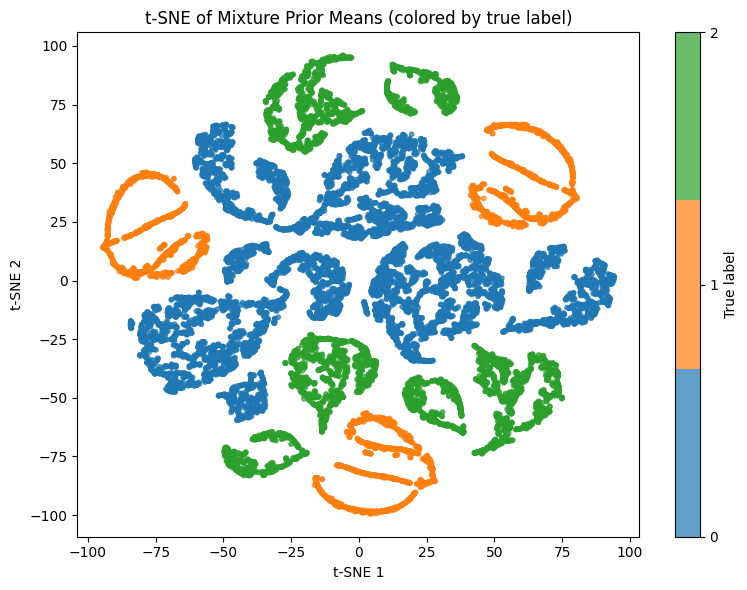

In [14]:
from torch.distributions import Categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

# === 1) Collect everything from DataLoader ===
prior.eval()
all_mu, all_logvar, all_pi, all_labels = [], [], [], []
with torch.no_grad():
    for smiles_enc, smiles_dec_input, smiles_dec_output, properties, label in tn:
        properties, label = properties.to(device), label.to(device)
        pi_logits, pi, mu_p, logvar_p = prior(properties, label)
        all_mu.append(mu_p)          # [b, L, K, D]
        all_logvar.append(logvar_p)
        all_pi.append(pi)            # [b, L, K]
        all_labels.append(label)     # [b]

# concatenate over batch
mu_p     = torch.cat(all_mu,     dim=0)  # [B, L, K, D]
logvar_p = torch.cat(all_logvar, dim=0)
pi_p     = torch.cat(all_pi,     dim=0)  # [B, L, K]
labels   = torch.cat(all_labels, dim=0)  # [B]

B, L, K = pi_p.shape
D        = mu_p.size(-1)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1) 준비된 텐서들 ---
# mu_p:    [B, L, K, D]   mixture prior means
# label:   [B]            true sequence labels in {0,1,2}
# device, tn( DataLoader ) 등은 이미 세팅된 상태라 가정

# 예시로 DataLoader에서 mu_p, label을 모았다면:
# mu_p = torch.cat(all_mu, dim=0)         # [B, L, K, D]
# label = torch.cat(all_labels, dim=0)    # [B]

B, L, K, D = mu_p.shape

# --- 2) 시퀀스 차원 평균 ---
mu_seq = mu_p.mean(dim=1)               # → [B, K, D]

# --- 3) flatten 배치×컴포넌트 ---
X = mu_seq.view(B*K, D).cpu().numpy()   # (B*K, D)

# --- 4) true labels 반복해서 붙이기 ---
label_np = labels.cpu().numpy()          # (B,)
labels_tsne = np.repeat(label_np, K)    # (B*K,)

# --- 5) 스케일링 + PCA ---
X_scaled = StandardScaler().fit_transform(X)
X_pca    = PCA(n_components=50, random_state=42).fit_transform(X_scaled)

# --- 6) t‑SNE 수행 ---
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=200,
            n_iter=1000,
            init='pca',
            random_state=42)
X_tsne = tsne.fit_transform(X_pca)      # (B*K, 2)

# --- 7) 시각화 ---
# true label이 0,1,2 → 컬러맵 준비
colors = ['#1f77b4','#ff7f0e','#2ca02c']  # blue, orange, green
cmap   = ListedColormap(colors)

plt.figure(figsize=(8,6))
sc = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=labels_tsne, cmap=cmap,
    s=10, alpha=0.7,
    vmin=0, vmax=2
)
cbar = plt.colorbar(sc, ticks=[0,1,2])
cbar.set_label("True label")
plt.title("t‑SNE of Mixture Prior Means (colored by true label)")
plt.xlabel("t‑SNE 1")
plt.ylabel("t‑SNE 2")
plt.tight_layout()
plt.show()

In [15]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

import datetime
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from pylab import *
status_out = widgets.Output()
display(status_out)
epoch = 400
model.train()
prior.eval()
for p in prior.parameters():
    p.requires_grad = False
progress = tqdm(range(epoch), desc="Training")
loss_arr = list()
real = list()
predict = list()
for i in progress:
    log_var_extract=[]
    batchloss = 0.0
    embeddings = []
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in train_dataloader:
        optim.zero_grad()


        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)
        label : torch.Tensor = label.to(device)

        logits, mu_q, logvar_q, z_q, prop_pred, encoded, z_classifier = model(smiles_enc, smiles_dec_input, properties, label)
        pi_logits, pi, mu_p, logvar_p = prior(properties, label)

        
        log_var_extract.append(torch.exp(0.5 * logvar_q).to(device))
        loss, stat = loss_fn(logits.float(), smiles_dec_output,
                                mu_q, logvar_q,
                                pi, mu_p, logvar_p,
                                prop_pred, properties,
                                pi_logits, label,
                                i)
        loss.backward()
        optim.step()


        batchloss += loss
        
    #Loss 값 추가
    loss = batchloss.cpu().item() / len(train_dataloader)
    loss_arr.append(loss)

    # 토큰 복원
    original_tokens = reverse_one_hot_encoding(smiles_dec_output[50], dataset.vocab)
    predicted_tokens = reverse_one_hot_encoding(logits[50], dataset.vocab)

    original_str = atomInSmiles.decode(' '.join(original_tokens))
    predicted_str = atomInSmiles.decode(' '.join(predicted_tokens))


    # 진행 바의 속성으로부터 필요한 값들 추출 (예시)
    elapsed = int(progress.format_dict.get("elapsed", 0))
    formatted_elap = str(datetime.timedelta(seconds=elapsed))
    rate = progress.format_dict.get("rate", None)
    sec_per_iter = 1 / rate if rate and rate != 0 else 0
    total = int(sec_per_iter * epoch)
    formatted_total = str(datetime.timedelta(seconds=total))
    
    # 고정된 상태 정보를 업데이트 (Output 위젯에 출력)
    with status_out:
        clear_output(wait=True)
        print(f"🔹 Elapsed: {formatted_elap} | sec/iter: {sec_per_iter:.3f}s")
        print("🔹 Total time: ", formatted_total)
        print(f"🔹 Step: {i+1}/{progress.total}")
        print("🔹 loss: {:0.6f}".format(loss))
        print(stat)
        print("sigma mean : {:0.6f}, ".format(torch.cat(log_var_extract).mean().item()),
              "sigma std : {:0.6f}".format(torch.cat(log_var_extract).std().mean()))
        print(f"[Epoch {i}] Original : {original_str}")
        print(f"[Epoch {i}] Predict  : {predicted_str}")
        plt.figure(figsize=(4, 4))
        plt.plot(loss_arr, label="loss")
        plt.yscale('log', base = 10)
        plt.show()

Output()

Training:   0%|          | 0/400 [00:00<?, ?it/s]

In [16]:
model.eval()

results = []
origin = []

properties_results=[]
properties_origin=[]
print(len(val_dataset))

with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in val_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)
        label = label.to(device)

        logits, mu_q, logvar_q, z_q, prop_pred, encoded, z_classifier = model(smiles_enc, smiles_dec_input, properties, label)
        pi_logits, pi, mu_p, logvar_p = prior(properties, label.to(device))

        results.append(logits)
        origin.append(smiles_dec_output)

        properties_results.append(prop_pred)
        properties_origin.append(properties)

results = torch.cat(results, dim=0)
origin = torch.cat(origin, dim=0)
results = nn.functional.softmax(results, dim=-1) 
argmax_indices = torch.argmax(results, dim=-1)
output = torch.nn.functional.one_hot(argmax_indices, num_classes=results.size(-1))

print(results.shape)
print(origin.shape)

from sklearn.metrics import mean_absolute_error
properties_origin=torch.cat(properties_origin,dim=0)
properties_results=torch.cat(properties_results,dim=0)

results_smiles = []
origin_smiles = []
for i in range(results.shape[0]):
    results_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab))))
    origin_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(origin[i], dataset.vocab))))



1567
torch.Size([1567, 265, 168])
torch.Size([1567, 265])


In [17]:


origin_smiles = [smiles.removesuffix("EOS").strip() for smiles in origin_smiles]
results_smiles = [smiles.removesuffix("EOS").strip() for smiles in results_smiles]


for i in range(len(results_smiles)):
    if(origin_smiles[i] != results_smiles[i]):
        print(i, "번째 다름!")
    print("real smiles      : ", origin_smiles[i])
    print("predicted smiles : ", results_smiles[i])


MAE = mean_absolute_error(origin.cpu(), torch.argmax(results.cpu(), dim=-1))
print("MAE : ", MAE)



real smiles      :  *OCC(C)N(CCC)CC(C)OC(*)=O
predicted smiles :  *OCC(C)N(CCC)CC(C)OC(*)=O
1 번째 다름!
real smiles      :  *OC(CC)C(NC(*)=O)C(=O)OCC
predicted smiles :  *OC(CC)C(CC(*)=O)C(=O)OCC
real smiles      :  *OCC(C)NC(=O)C(C)C(CC)OC(*)=O
predicted smiles :  *OCC(C)NC(=O)C(C)C(CC)OC(*)=O
real smiles      :  *NCCCCC(=O)NCC(CC)NC(*)=O
predicted smiles :  *NCCCCC(=O)NCC(CC)NC(*)=O
4 번째 다름!
real smiles      :  *OCC(NC(*)=O)C(=O)NCCCC
predicted smiles :  *OCC(CC(*)=O)C(=O)NCCCC
real smiles      :  *OCC(=O)NCC(COC(*)=O)C(C)C
predicted smiles :  *OCC(=O)NCC(COC(*)=O)C(C)C
6 번째 다름!
real smiles      :  *OC(C=O)C(O)=C(O)COC(*)=O
predicted smiles :  *OC(C=C)N(=)=O(O)=OC(*)=O
real smiles      :  *OCC(C=C)NC(=O)CCCCOC(*)=O
predicted smiles :  *OCC(C=C)NC(=O)CCCCOC(*)=O
real smiles      :  *NCCCN(C)CC(CSC)OC(*)=O
predicted smiles :  *NCCCN(C)CC(CSC)OC(*)=O
9 번째 다름!
real smiles      :  *NCC(COC(C)(C)C)OC(*)=O
predicted smiles :  *NCC(COC(C)(C)O)OC(*)=O
real smiles      :  *OC(C)C(C)NC(CC)CCOC(*)=

In [18]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_valid(smiles):
    return Chem.MolFromSmiles(smiles) is not None

TS = 0.0
canbe = 0
notbe = 0

for sm, orig in zip(results_smiles, origin_smiles):
    if is_valid(sm) and is_valid(orig):
        sim = tanimoto_similarity(sm, orig)
        TS += sim
        canbe += 1
    else:
        notbe += 1

if canbe > 0:
    print("Tanimoto Similarity : ", TS / canbe)
else:
    print("No valid molecules to compare.")

print("가능한 분자 개수 :", canbe)
print("불가능한 분자 개수 :", notbe)
print("Valid fraction      :", canbe / len(results_smiles))


Tanimoto Similarity :  0.9249637458696798
가능한 분자 개수 : 1445
불가능한 분자 개수 : 122
Valid fraction      : 0.9221442246330568


In [19]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, shape: {param.shape}")

state = model.state_dict()

# state 딕셔너리의 키 확인 (해당 키 이름은 named_parameters()와 동일)
print(state.keys())


Layer: encoder.normLayer.gamma, shape: torch.Size([256])
Layer: encoder.normLayer.beta, shape: torch.Size([256])
Layer: encoder.encoderLayer.self_attn.in_proj_weight, shape: torch.Size([768, 256])
Layer: encoder.encoderLayer.self_attn.in_proj_bias, shape: torch.Size([768])
Layer: encoder.encoderLayer.self_attn.out_proj.weight, shape: torch.Size([256, 256])
Layer: encoder.encoderLayer.self_attn.out_proj.bias, shape: torch.Size([256])
Layer: encoder.encoderLayer.linear1.weight, shape: torch.Size([64, 256])
Layer: encoder.encoderLayer.linear1.bias, shape: torch.Size([64])
Layer: encoder.encoderLayer.linear2.weight, shape: torch.Size([256, 64])
Layer: encoder.encoderLayer.linear2.bias, shape: torch.Size([256])
Layer: encoder.encoderLayer.norm1.weight, shape: torch.Size([256])
Layer: encoder.encoderLayer.norm1.bias, shape: torch.Size([256])
Layer: encoder.encoderLayer.norm2.weight, shape: torch.Size([256])
Layer: encoder.encoderLayer.norm2.bias, shape: torch.Size([256])
Layer: encoder.encod

In [20]:
save_path = "model_weights_dmodel256.pth"
torch.save(model.state_dict(), save_path)
save_path = "model_weights_prior.pth"
torch.save(prior.state_dict(), save_path)

In [10]:
save_path = "model_weights_dmodel256.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

save_path = "model_weights_prior.pth"
state_dict = torch.load(save_path)
prior.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
model.eval()
prior.eval()
results = []
origin = []
z_tn = []
mean_tn = []
log_var_tn = []
mu_p_tn=[]
var_p_tn=[]
prop = []
labels = []
pi_p = []
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in tn:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)
        label = label.to(device)

        logits, mu_q, logvar_q, z_q, prop_pred, encoded, z_classifier = model(smiles_enc, smiles_dec_input, properties,label)
        pi_logits, pi, mu_p, logvar_p = prior(properties, label.to(device))

        mean_tn.append(mu_q)
        log_var_tn.append(logvar_q)
        z_tn.append(z_q)
        mu_p_tn.append(mu_p)
        var_p_tn.append(logvar_p)
        prop.append(properties)
        labels.append(label)
        pi_p.append(pi)

In [12]:
z_tn = torch.cat(z_tn, dim=0)
mean_tn = torch.cat(mean_tn, dim=0)
log_var_tn = torch.cat(log_var_tn, dim=0)
mu_p_tn = torch.cat(mu_p_tn, dim=0)
var_p_tn = torch.cat(var_p_tn, dim=0)
prop = torch.cat(prop, dim=0)
labels = torch.cat(labels, dim=0)
pi_p = torch.cat(pi_p, dim=0)

In [13]:
print(z_tn.shape)
print(mean_tn.shape)
print(log_var_tn.shape)
print("sigma mean :", log_var_tn.mean().item())
print("sigma std :", log_var_tn.std().item())



torch.Size([6270, 265, 64])
torch.Size([6270, 265, 64])
torch.Size([6270, 265, 64])
sigma mean : -0.009751503355801105
sigma std : 0.3036954402923584


/home/kiket/torch.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


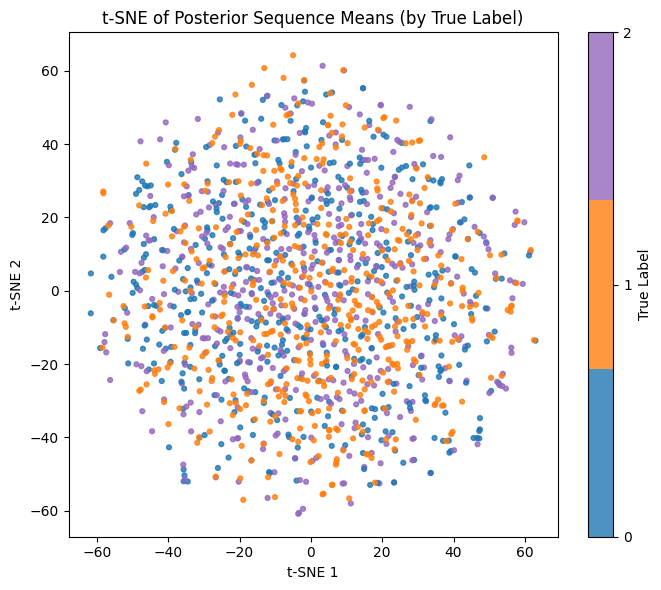

Same-mode distance:    mean = 0.4584, std = 0.1167
Closest-other distance: mean = 0.7077, std = 0.0781


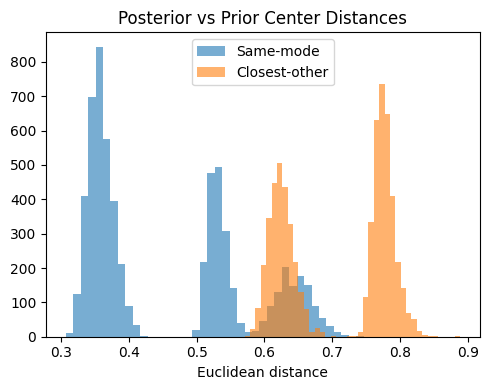

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def compute_classwise_kl_np(
    q_mu_np,       # numpy array, shape (B, L, D)
    logvar_q_np,   # numpy array, shape (B, L, D)
    mu_p_np,       # numpy array, shape (B, L, K, D)
    logvar_p_np,   # numpy array, shape (B, L, K, D)
    true_labels_np # numpy array of ints, shape (B,), values in {0,1,2}
):
    """
    NumPy 버전: 각 시퀀스 b에 대해
      Posterior = N(mu_q_seq[b], var_q_seq[b])
      Prior component = N(mu_p_seq[b, c_b], var_p_seq[b, c_b])
    의 analytic Gaussian-Gaussian KL을 구하고, 클래스별로 평균을 내서 반환.

    Args:
      q_mu_np       : posterior mean, shape (B, L, D)
      logvar_q_np   : posterior log-variance, shape (B, L, D)
      mu_p_np       : prior means,   shape (B, L, K, D)
      logvar_p_np   : prior log-variance, shape (B, L, K, D)
      true_labels_np: true class labels,   shape (B,), each ∈ {0,...,K-1}

    Returns:
      kl_values: dict {0: KL_class0, 1: KL_class1, 2: KL_class2}
    """
    B, L, D = q_mu_np.shape
    _, _, K, _ = mu_p_np.shape

    # 1) Posterior var, Prior var 계산
    var_q_full = np.exp(logvar_q_np)               # (B, L, D)
    # 시퀀스 차원 L에 대해 평균내기
    mu_q_seq  = np.mean(q_mu_np, axis=1)           # (B, D)
    var_q_seq = np.mean(var_q_full, axis=1)        # (B, D)

    # 2) Prior 시퀀스 평균 계산
    mu_p_seq  = np.mean(mu_p_np, axis=1)           # (B, K, D)
    var_p_full= np.exp(logvar_p_np)                # (B, L, K, D)
    var_p_seq = np.mean(var_p_full, axis=1)        # (B, K, D)

    # 3) 각 배치 b마다 해당 true_labels_np[b] 컴포넌트만 선택
    prior_mu_sel  = mu_p_seq[np.arange(B), true_labels_np]   # (B, D)
    prior_var_sel = var_p_seq[np.arange(B), true_labels_np]  # (B, D)

    # 4) Analytic KL for Gaussian: KL(N_q || N_p) per sequence
    #    KL = 0.5 * [ log(var_p/var_q) + (var_q + (mu_q - mu_p)^2) / var_p - 1 ]
    eps = 1e-8
    term1 = np.log(prior_var_sel + eps) - np.log(var_q_seq + eps)        # (B, D)
    term2 = (var_q_seq + (mu_q_seq - prior_mu_sel)**2) / (prior_var_sel + eps)  # (B, D)
    kl_per_dim = 0.5 * (term1 + term2 - 1.0)                             # (B, D)
    kl_per_seq = np.sum(kl_per_dim, axis=1)                              # (B,)

    # 5) 클래스별 평균 KL 계산
    kl_values = {}
    for c in range(K):
        mask_c = (true_labels_np == c)
        if np.sum(mask_c) > 0:
            kl_values[c] = float(np.mean(kl_per_seq[mask_c]))
        else:
            kl_values[c] = float('nan')

    return kl_values


def confusion_latent_purity_np(
    q_mu_np,       # numpy array, shape (B, L, D)
    pi_p_np,       # numpy array, shape (B, L, K)
    mu_p_np,       # numpy array, shape (B, L, K, D)
    logvar_p_np,   # numpy array, shape (B, L, K, D)
    true_labels_np # numpy array of ints, shape (B,), values in {0,1,2}
):
    """
    NumPy 버전: 각 시퀀스 b의 posterior mean(mu_q_seq[b])을 Prior Mixture K개 모드
    (mu_p_seq[b,k], var_p_seq[b,k], pi_p_seq[b,k]) 중
    MAP(=argmax log π_k + log N)으로 할당한 뒤,
    True Label과 비교하여 Confusion Matrix 및 classification report를 출력.

    Args:
      q_mu_np       : posterior mean,   shape (B, L, D)
      pi_p_np       : prior weights,    shape (B, L, K)
      mu_p_np       : prior means,      shape (B, L, K, D)
      logvar_p_np   : prior log-variance, shape (B, L, K, D)
      true_labels_np: true class labels,   shape (B,), values ∈ {0,...,K-1}

    Returns:
      cm: (K×K) confusion matrix
      acc: overall assignment accuracy (float)
    """
    B, L, D = q_mu_np.shape
    _, _, K, _ = mu_p_np.shape

    # 1) Posterior sequence mean (L 차원 평균)
    q_seq_np = np.mean(q_mu_np, axis=1)  # (B, D)

    # 2) Prior 시퀀스 평균 (L 차원 평균)
    mu_p_seq_np     = np.mean(mu_p_np, axis=1)       # (B, K, D)
    logvar_p_seq_np = np.mean(logvar_p_np, axis=1)   # (B, K, D)
    pi_p_seq_np     = np.mean(pi_p_np, axis=1)       # (B, K)

    # 3) MAP 할당: 각 b, 각 k에 대해 log π + log N(q_seq[b]; mu_p_seq[b,k], sigma_p_seq[b,k])
    #    (a) Prior sigma: (B, K, D)
    var_p_seq_np = np.exp(logvar_p_seq_np)            # (B, K, D)
    std_p_seq_np = np.sqrt(var_p_seq_np + 1e-8)       # (B, K, D)

    #    (b) log N 계산:    
    #      log N(x; mu, sigma^2) = -0.5 * [ ((x-mu)^2 / sigma^2) + log(2π sigma^2 ) ]
    #      → sum over D dimension
    q_expanded = q_seq_np[:, None, :]                 # (B, 1, D)
    #    (c) 거리 제곱/(2σ^2)
    diff = (q_expanded - mu_p_seq_np)**2              # (B, K, D)
    term_sq = diff / (var_p_seq_np + 1e-8)            # (B, K, D)
    log_det = np.log(2.0 * np.pi * var_p_seq_np + 1e-8)  # (B, K, D)
    log_Nk = -0.5 * np.sum(term_sq + log_det, axis=2)    # (B, K)

    #    (d) log π (mixture weight)
    log_pi_p_np = np.log(pi_p_seq_np + 1e-8)          # (B, K)

    #    (e) joint log-likelihood = log π + log N
    log_joint = log_pi_p_np + log_Nk                  # (B, K)

    #    (f) MAP assign: 가장 큰 인덱스
    assigned = np.argmax(log_joint, axis=1)           # (B,)

    # 4) Confusion Matrix / Classification Report
    y_true = true_labels_np
    y_pred = assigned

    acc = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(K)))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=list(range(K)), yticklabels=list(range(K)))
    plt.xlabel("Predicted mode index")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix (Latent Purity)\nAccuracy = {acc:.3f}")
    plt.tight_layout()
    plt.show()

    print("Classification Report (by latent assignment):")
    print(classification_report(y_true, y_pred, labels=list(range(K))))

    return cm, acc


# ================================
# 사용 예시
# ================================
if __name__ == "__main__":
    # 1) PyTorch 텐서가 있는 경우, NumPy로 변환 예시
    #    (아래는 반드시 실제 배치 데이터 형태에 맞춰 치환하세요)
    #
    # mu_q_t       = ...  # shape [B, L, D], torch.Tensor
    # logvar_q_t   = ...  # shape [B, L, D], torch.Tensor
    # mu_p_t       = ...  # shape [B, L, K, D], torch.Tensor
    # logvar_p_t   = ...  # shape [B, L, K, D], torch.Tensor
    # pi_p_t       = ...  # shape [B, L, K], torch.Tensor
    # labels_t     = ...  # shape [B,], torch.LongTensor, values in {0,1,2}
    #
    # # GPU → CPU → NumPy
    # q_mu_np       = mu_q_t.detach().cpu().numpy()
    # logvar_q_np   = logvar_q_t.detach().cpu().numpy()
    # mu_p_np       = mu_p_t.detach().cpu().numpy()
    # logvar_p_np   = logvar_p_t.detach().cpu().numpy()
    # pi_p_np       = pi_p_t.detach().cpu().numpy()
    # true_labels_np= labels_t.detach().cpu().numpy()

    # 여기서는 “예시용 임의 데이터”를 생성하여 함수 호출 예시를 보여줍니다.
    B, L, K, D = 200, 50, 3, 16
    np.random.seed(0)

    # 임의의 Posterior (mu_q, logvar_q)
    mu_q_np     = mean_tn.detach().cpu().numpy()
    logvar_q_np = var_p_tn.detach().cpu().numpy() - 2.0  # 다소 작은 분산 값

    # 임의의 Prior Mixture (mu_p, logvar_p, pi_p)
    mu_p_np     = mu_p_tn.detach().cpu().numpy()
    logvar_p_np = np.random.randn(B, L, K, D) - 1.5
    pi_p_np     = np.abs(np.random.randn(B, L, K))
    # normalize pi_p_np over K axis
    pi_p_np = pi_p_np / np.sum(pi_p_np, axis=2, keepdims=True)

    # 임의의 True labels (0,1,2 중 랜덤)
    true_labels_np = np.random.randint(0, K, size=(B,))

    # 1) 클래스별 KL 계산
    kl_per_class = compute_classwise_kl_np(
        mu_q_np, logvar_q_np,
        mu_p_np, logvar_p_np,
        true_labels_np
    )
    print("Class‑wise KL Divergence (Posterior  vs  Prior component):")
    for c, v in kl_per_class.items():
        print(f"  Class {c}: KL = {v:.4f}")

    # 2) Confusion Matrix / Latent Purity 확인
    cm, acc = confusion_latent_purity_np(
        mu_q_np, pi_p_np, mu_p_np, logvar_p_np,
        true_labels_np
    )
    print("Overall Latent Assignment Accuracy =", acc)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def compute_classwise_kl_np(
    q_mu_np,       # numpy array, shape (B, L, D)
    logvar_q_np,   # numpy array, shape (B, L, D)
    mu_p_np,       # numpy array, shape (B, L, K, D)
    logvar_p_np,   # numpy array, shape (B, L, K, D)
    true_labels_np # numpy array of ints, shape (B,), values in {0,1,2}
):
    """
    NumPy 버전: 각 시퀀스 b에 대해
      Posterior = N(mu_q_seq[b], var_q_seq[b])
      Prior component = N(mu_p_seq[b, c_b], var_p_seq[b, c_b])
    의 analytic Gaussian-Gaussian KL을 구하고, 클래스별로 평균을 내서 반환.

    Args:
      q_mu_np       : posterior mean, shape (B, L, D)
      logvar_q_np   : posterior log-variance, shape (B, L, D)
      mu_p_np       : prior means,   shape (B, L, K, D)
      logvar_p_np   : prior log-variance, shape (B, L, K, D)
      true_labels_np: true class labels,   shape (B,), each ∈ {0,...,K-1}

    Returns:
      kl_values: dict {0: KL_class0, 1: KL_class1, 2: KL_class2}
    """
    B, L, D = q_mu_np.shape
    _, _, K, _ = mu_p_np.shape

    # 1) Posterior var, Prior var 계산
    var_q_full = np.exp(logvar_q_np)               # (B, L, D)
    # 시퀀스 차원 L에 대해 평균내기
    mu_q_seq  = np.mean(q_mu_np, axis=1)           # (B, D)
    var_q_seq = np.mean(var_q_full, axis=1)        # (B, D)

    # 2) Prior 시퀀스 평균 계산
    mu_p_seq  = np.mean(mu_p_np, axis=1)           # (B, K, D)
    var_p_full= np.exp(logvar_p_np)                # (B, L, K, D)
    var_p_seq = np.mean(var_p_full, axis=1)        # (B, K, D)

    # 3) 각 배치 b마다 해당 true_labels_np[b] 컴포넌트만 선택
    prior_mu_sel  = mu_p_seq[np.arange(B), true_labels_np]   # (B, D)
    prior_var_sel = var_p_seq[np.arange(B), true_labels_np]  # (B, D)

    # 4) Analytic KL for Gaussian: KL(N_q || N_p) per sequence
    #    KL = 0.5 * [ log(var_p/var_q) + (var_q + (mu_q - mu_p)^2) / var_p - 1 ]
    eps = 1e-8
    term1 = np.log(prior_var_sel + eps) - np.log(var_q_seq + eps)        # (B, D)
    term2 = (var_q_seq + (mu_q_seq - prior_mu_sel)**2) / (prior_var_sel + eps)  # (B, D)
    kl_per_dim = 0.5 * (term1 + term2 - 1.0)                             # (B, D)
    kl_per_seq = np.sum(kl_per_dim, axis=1)                              # (B,)

    # 5) 클래스별 평균 KL 계산
    kl_values = {}
    for c in range(K):
        mask_c = (true_labels_np == c)
        if np.sum(mask_c) > 0:
            kl_values[c] = float(np.mean(kl_per_seq[mask_c]))
        else:
            kl_values[c] = float('nan')

    return kl_values


def confusion_latent_purity_np(
    q_mu_np,       # numpy array, shape (B, L, D)
    pi_p_np,       # numpy array, shape (B, L, K)
    mu_p_np,       # numpy array, shape (B, L, K, D)
    logvar_p_np,   # numpy array, shape (B, L, K, D)
    true_labels_np # numpy array of ints, shape (B,), values in {0,1,2}
):
    """
    NumPy 버전: 각 시퀀스 b의 posterior mean(mu_q_seq[b])을 Prior Mixture K개 모드
    (mu_p_seq[b,k], var_p_seq[b,k], pi_p_seq[b,k]) 중
    MAP(=argmax log π_k + log N)으로 할당한 뒤,
    True Label과 비교하여 Confusion Matrix 및 classification report를 출력.

    Args:
      q_mu_np       : posterior mean,   shape (B, L, D)
      pi_p_np       : prior weights,    shape (B, L, K)
      mu_p_np       : prior means,      shape (B, L, K, D)
      logvar_p_np   : prior log-variance, shape (B, L, K, D)
      true_labels_np: true class labels,   shape (B,), values ∈ {0,...,K-1}

    Returns:
      cm: (K×K) confusion matrix
      acc: overall assignment accuracy (float)
    """
    B, L, D = q_mu_np.shape
    _, _, K, _ = mu_p_np.shape

    # 1) Posterior sequence mean (L 차원 평균)
    q_seq_np = np.mean(q_mu_np, axis=1)  # (B, D)

    # 2) Prior 시퀀스 평균 (L 차원 평균)
    mu_p_seq_np     = np.mean(mu_p_np, axis=1)       # (B, K, D)
    logvar_p_seq_np = np.mean(logvar_p_np, axis=1)   # (B, K, D)
    pi_p_seq_np     = np.mean(pi_p_np, axis=1)       # (B, K)

    # 3) MAP 할당: 각 b, 각 k에 대해 log π + log N(q_seq[b]; mu_p_seq[b,k], sigma_p_seq[b,k])
    #    (a) Prior sigma: (B, K, D)
    var_p_seq_np = np.exp(logvar_p_seq_np)            # (B, K, D)
    std_p_seq_np = np.sqrt(var_p_seq_np + 1e-8)       # (B, K, D)

    #    (b) log N 계산:    
    #      log N(x; mu, sigma^2) = -0.5 * [ ((x-mu)^2 / sigma^2) + log(2π sigma^2 ) ]
    #      → sum over D dimension
    q_expanded = q_seq_np[:, None, :]                 # (B, 1, D)
    #    (c) 거리 제곱/(2σ^2)
    diff = (q_expanded - mu_p_seq_np)**2              # (B, K, D)
    term_sq = diff / (var_p_seq_np + 1e-8)            # (B, K, D)
    log_det = np.log(2.0 * np.pi * var_p_seq_np + 1e-8)  # (B, K, D)
    log_Nk = -0.5 * np.sum(term_sq + log_det, axis=2)    # (B, K)

    #    (d) log π (mixture weight)
    log_pi_p_np = np.log(pi_p_seq_np + 1e-8)          # (B, K)

    #    (e) joint log-likelihood = log π + log N
    log_joint = log_pi_p_np + log_Nk                  # (B, K)

    #    (f) MAP assign: 가장 큰 인덱스
    assigned = np.argmax(log_joint, axis=1)           # (B,)

    # 4) Confusion Matrix / Classification Report
    y_true = true_labels_np
    y_pred = assigned

    acc = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(K)))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=list(range(K)), yticklabels=list(range(K)))
    plt.xlabel("Predicted mode index")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix (Latent Purity)\nAccuracy = {acc:.3f}")
    plt.tight_layout()
    plt.show()

    print("Classification Report (by latent assignment):")
    print(classification_report(y_true, y_pred, labels=list(range(K))))

    return cm, acc


# ================================
# 사용 예시
# ================================
if __name__ == "__main__":
    # 1) PyTorch 텐서가 있는 경우, NumPy로 변환 예시
    #    (아래는 반드시 실제 배치 데이터 형태에 맞춰 치환하세요)
    #
    # mu_q_t       = ...  # shape [B, L, D], torch.Tensor
    # logvar_q_t   = ...  # shape [B, L, D], torch.Tensor
    # mu_p_t       = ...  # shape [B, L, K, D], torch.Tensor
    # logvar_p_t   = ...  # shape [B, L, K, D], torch.Tensor
    # pi_p_t       = ...  # shape [B, L, K], torch.Tensor
    # labels_t     = ...  # shape [B,], torch.LongTensor, values in {0,1,2}
    #
    # # GPU → CPU → NumPy
    # q_mu_np       = mu_q_t.detach().cpu().numpy()
    # logvar_q_np   = logvar_q_t.detach().cpu().numpy()
    # mu_p_np       = mu_p_t.detach().cpu().numpy()
    # logvar_p_np   = logvar_p_t.detach().cpu().numpy()
    # pi_p_np       = pi_p_t.detach().cpu().numpy()
    # true_labels_np= labels_t.detach().cpu().numpy()

    # 여기서는 “예시용 임의 데이터”를 생성하여 함수 호출 예시를 보여줍니다.
    B, L, K, D = 200, 50, 3, 16
    np.random.seed(0)

    # 임의의 Posterior (mu_q, logvar_q)
    mu_q_np     = mean_tn.detach().cpu().numpy()
    logvar_q_np = log_var_tn.detach().cpu().numpy()

    # 임의의 Prior Mixture (mu_p, logvar_p, pi_p)
    mu_p_np     = mu_p_tn.detach().cpu().numpy()
    logvar_p_np = var_p_tn.detach().cpu().numpy()
    pi_p_np     = pi_p.detach().cpu().numpy()
    # normalize pi_p_np over K axis
    pi_p_np = pi_p_np / np.sum(pi_p_np, axis=2, keepdims=True)

    # 임의의 True labels (0,1,2 중 랜덤)
    true_labels_np = labels.long().detach().cpu().numpy()

    # 1) 클래스별 KL 계산
    kl_per_class = compute_classwise_kl_np(
        mu_q_np, logvar_q_np,
        mu_p_np, logvar_p_np,
        true_labels_np
    )
    print("Class‑wise KL Divergence (Posterior  vs  Prior component):")
    for c, v in kl_per_class.items():
        print(f"  Class {c}: KL = {v:.4f}")

    # 2) Confusion Matrix / Latent Purity 확인
    cm, acc = confusion_latent_purity_np(
        mu_q_np, pi_p_np, mu_p_np, logvar_p_np,
        true_labels_np
    )
    print("Overall Latent Assignment Accuracy =", acc)
